In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
from domino.evaluate import run_sdm
from domino.sdm import MultiaccuracySDM, GeorgeSDM, ConfusionSDM, MixtureModelSDM


/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [3]:
inp = run_sdm.inp(30714)
data_dp = inp["data_dp"].load()
emb_dp = inp["emb_dp"].load()


id_column = inp["id_column"]
data_emb_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[[id_column, "emb"]], on=id_column
)

In [4]:
# sdm = GeorgeSDM(
#     concat_loss_component=True, 
#     n_slices=5, 
#     n_clusters=10, 
#     n_components=128, 
#     reduction_method="pca"
# )
# sdm = MixtureModelSDM(
#     weight_y_log_likelihood=10
# )
sdm = ConfusionSDM()


In [5]:
out = sdm.fit(data_emb_dp)

In [8]:
out = sdm.transform(data_emb_dp)

In [9]:
from domino.metrics import compute_sdm_metrics
compute_sdm_metrics(out)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
0,0,0,0.250480,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,0.250480,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0,0.910296,1.0,0.68,0.33,0.161972,0.232394,0.316901,0.612676,0.107011
3,3,0,0.588745,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.387324,0.014597
4,4,0,0.500000,0.0,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.000000


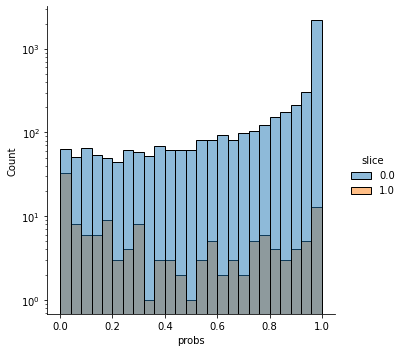

In [39]:
import seaborn as sns
dp = out
plot_dp = dp.lz[dp["target"] ==1]
slices = plot_dp["slices"].data.squeeze()
probs = plot_dp["probs"].data[:, 1]
sns.displot({"probs": probs, "slice": slices}, x="probs", hue="slice")

plt.yscale("log")

,image (ImageColumn),target (NumpyArrayColumn),synset (PandasSeriesColumn)
0,,1,jean.n.01
1,,1,jean.n.01
2,,1,jean.n.01
3,,1,jean.n.01
4,,1,jean.n.01
5,,1,jean.n.01
6,,1,jean.n.01
7,,1,maillot.n.01
8,,1,jean.n.01
9,,1,jean.n.01

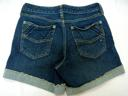
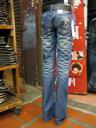
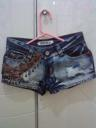
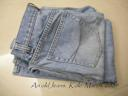
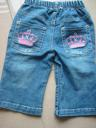
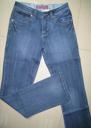
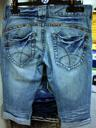
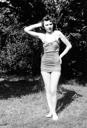
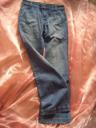
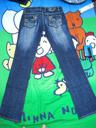

In [26]:
dp = out
pred_slice_idx = 1
dp.lz[(-dp["pred_slices"].data[:, pred_slice_idx]).argsort()[:10]][["image", "target", "synset"]]

In [12]:
dp = out 
pred_slice_idx = 0
dp.lz[(dp["slices"].data == 1).squeeze()][["image", "target", "synset"]]["synset"].unique()

array(['jean.n.01'], dtype=object)

Text(0, 0.5, 'Residual')

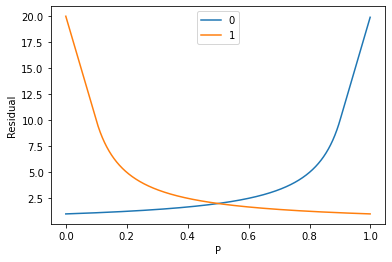

In [24]:
import matplotlib.pyplot as plt
import numpy as np
def res(p, y):
    return y * ((p>=0.1)/(p + 1e-20) + (p<0.1) * (20 - 100  * p)) +\
(1-y) * ((p < 0.9)/(1 - p + 1e-20) + (p>=0.9) * (100 * p - 80))
plt.plot(np.arange(0, 1.0, 0.001), res(np.arange(0., 1, 0.001), 0))
plt.plot(np.arange(0, 1.0, 0.001), res(np.arange(0., 1, 0.001), 1))
plt.legend(['0', '1'])
plt.xlabel('P')
plt.ylabel('Residual')

In [16]:
from domino.evaluate import score_sdms
score_df = score_sdms.out().load()

In [17]:
plot_df = score_df.iloc[
    score_df.reset_index()
    .groupby(["target_name", "slice_name", "slice_idx", "sdm_class", "alpha"])["auroc"]
    .idxmax()
    .astype(int)
].copy()


<AxesSubplot:xlabel='precision_at_10', ylabel='sdm_class'>

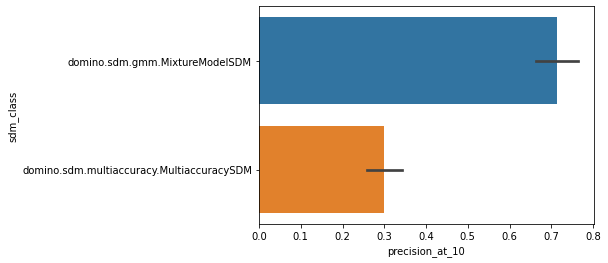

In [18]:
import seaborn as sns
sns.barplot(data=plot_df, x="precision_at_10", y="sdm_class")

In [21]:
plot_df[
    (plot_df["precision_at_10"] < 0.5)
    & (plot_df["sdm_class"] == "domino.sdm.multiaccuracy.MultiaccuracySDM")
]


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_name,run_sdm_run_id,emb_group,alpha,sdm_class,slice_name
7760,0,0,0.260322,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.444444,0.005877,big_cat.n.01,32246,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,jaguar.n.01
7640,0,0,0.309698,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.541667,0.007905,big_cat.n.01,32244,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,leopard.n.02
7680,0,0,0.350363,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.580645,0.005581,big_cat.n.01,32243,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,lion.n.01
7722,2,0,0.367771,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.137931,0.008658,big_cat.n.01,32242,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,tiger.n.02
4804,4,0,0.906611,0.3,0.36,0.26,0.193548,0.279570,0.376344,0.000000,0.000000,bird.n.01,31939,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,crane.n.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,1,0,0.836754,0.1,0.08,0.08,0.022989,0.091954,0.229885,0.850575,0.034149,vehicle.n.01,31526,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,truck.n.01
1561,1,0,0.863707,0.1,0.20,0.16,0.105263,0.168421,0.263158,0.726316,0.040327,vehicle.n.01,31530,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,van.n.05
1042,2,0,0.809975,0.2,0.20,0.10,0.073684,0.105263,0.189474,0.063158,0.016620,vehicle.n.01,31502,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,vessel.n.02
1324,4,0,0.801310,0.1,0.12,0.10,0.044944,0.112360,0.157303,0.056180,0.017668,vehicle.n.01,31516,clip,0.03,domino.sdm.multiaccuracy.MultiaccuracySDM,wagon.n.01


In [5]:
import numpy as np
x = np.zeros((10,4))

In [7]:
x[[1,2,5,7]] = 1

In [8]:
x

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])